In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [14]:
df = pd.read_csv('AQI_DaNang_Updated.csv')
df.head()

,date,pm25,pm10,o3,no2,so2,co,AQI_pm25,AQI_pm10,AQI_o3,AQI_no2,AQI_so2,AQI_co,AQI
0,2019-01-01,26.0,8.0,67.0,9.0,10.0,1.0,52.0,8.0,20.9375,4.5,4.0,5.0,52.0
1,2019-01-02,26.0,11.0,47.0,13.0,6.0,2.0,52.0,11.0,14.6875,6.5,2.4,10.0,52.0
2,2019-01-03,32.0,15.0,38.0,9.0,1.0,1.0,64.0,15.0,11.8750,4.5,0.4,5.0,64.0
3,2019-01-04,40.0,15.0,69.0,11.0,1.0,1.0,80.0,15.0,21.5625,5.5,0.4,5.0,80.0
4,2019-01-05,45.0,32.0,54.0,11.0,1.0,4.0,90.0,32.0,16.8750,5.5,0.4,20.0,90.0


In [15]:
df.AQI.min()

10.0

In [16]:
cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI']

In [17]:
df = df[cols]
df.head()

,pm25,pm10,o3,no2,so2,co,AQI
0,26.0,8.0,67.0,9.0,10.0,1.0,52.0
1,26.0,11.0,47.0,13.0,6.0,2.0,52.0
2,32.0,15.0,38.0,9.0,1.0,1.0,64.0
3,40.0,15.0,69.0,11.0,1.0,1.0,80.0
4,45.0,32.0,54.0,11.0,1.0,4.0,90.0


In [18]:
# fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,10))
# for i, ax in enumerate(axes.flatten()):
#     data = df[df.columns[i]]
#     ax.plot(data, color='blue', linewidth=1)
#     # Decorations
#     ax.set_title(df.columns[i])
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)

# plt.tight_layout();

### 7. Cointegration Test ###

In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pm25   ::  553.43    > 111.7797  =>   True
pm10   ::  341.37    > 83.9383   =>   True
o3     ::  202.44    > 60.0627   =>   True
no2    ::  121.23    > 40.1749   =>   True
so2    ::  67.26     > 24.2761   =>   True
co     ::  23.91     > 12.3212   =>   True
AQI    ::  1.31      > 4.1296    =>   False


In [20]:
# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR  

time_series = df[cols]
train_data = time_series[:int(0.7*len(time_series))]
test_data = time_series[int(0.7*len(time_series)):]

### 9. Check for Stationarity and Make the Time Series Stationary ###

In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [22]:
# ADF Test on each column
for name, column in train_data.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5225
 No. Lags Chosen       = 17
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pm10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.638
 No. Lags Chosen       = 2
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "o3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
df_diff = train_data.diff().dropna()
df_diff

,pm25,pm10,o3,no2,so2,co,AQI
1,0.0,3.0,-20.0,4.0,-4.0,1.0,0.000000
2,6.0,4.0,-9.0,-4.0,-5.0,-1.0,12.000000
3,8.0,0.0,31.0,2.0,0.0,0.0,16.000000
4,5.0,17.0,-15.0,0.0,0.0,3.0,10.000000
5,40.0,11.0,18.0,3.0,0.0,0.0,63.571429
...,...,...,...,...,...,...,...
1380,-7.0,-5.0,5.0,0.0,0.0,11.0,1.500000
1381,14.0,-7.0,9.0,0.0,0.0,-12.0,12.500000
1382,-8.0,-5.0,-8.0,0.0,0.0,12.0,-12.500000
1383,6.0,0.0,-17.0,0.0,0.0,-12.0,8.500000


In [25]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.4155
 No. Lags Chosen       = 21
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pm10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.828
 No. Lags Chosen       = 17
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "o3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

### 10. Xây dựng mô hình VAR ###

In [26]:
model = VAR(df_diff)

In [27]:
# Tìm Lag Order
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,30.85,30.87,2.490e+13,30.86
1,29.30,29.52,5.327e+12,29.38
2,28.87,29.27,3.451e+12,29.02
3,28.63,29.22*,2.717e+12,28.85
4,28.54,29.31,2.481e+12,28.83
5,28.48,29.44,2.327e+12,28.83
6,28.38,29.52,2.108e+12,28.81*
7,28.34,29.67,2.023e+12,28.83
8,28.33,29.85,2.020e+12,28.90
9,28.32,30.03,1.999e+12,28.96


In [28]:
# lag_order = 10
fitted_model = model.fit(10)
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Jun, 2024
Time:                     20:46:31
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    30.1710
Nobs:                     1374.00    HQIC:                   28.9881
Log likelihood:          -32579.3    FPE:                1.91641e+12
AIC:                      28.2808    Det(Omega_mle):     1.34686e+12
--------------------------------------------------------------------
Results for equation pm25
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.082525         0.358284           -0.230           0.818
L1.pm25         -0.932358         0.068555          -13.600           0.000
L1.pm10          0.756478         0.028623           26.429           0.000
L1.o3

In [29]:
lag_order = fitted_model.k_ar
lag_order

10

In [30]:
predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[-4.54634167e+00,  1.55694024e+00,  2.89186318e+00, ...,
         1.33194687e+00,  1.43365961e+00, -3.97334720e+00],
       [-1.20169878e+01,  6.70710298e+00, -9.33630772e+00, ...,
        -3.63732323e-01,  7.52421576e-02, -2.51918455e+01],
       [ 4.20057371e+00, -3.54855629e+00, -9.47517191e+00, ...,
         1.46990182e-01,  1.75016586e+00,  5.71464738e+00],
       ...,
       [-3.18016672e-02, -8.77624340e-03, -1.27391333e-02, ...,
         8.37496573e-03,  1.10547025e-03, -4.47816606e-02],
       [-3.18016672e-02, -8.77624340e-03, -1.27391333e-02, ...,
         8.37496573e-03,  1.10547025e-03, -4.47816606e-02],
       [-3.18016672e-02, -8.77624340e-03, -1.27391333e-02, ...,
         8.37496573e-03,  1.10547025e-03, -4.47816606e-02]])

In [31]:
df_forecast = pd.DataFrame(predictions, index=df.index[int(0.7*len(time_series)):], columns=df.columns + '_1d')
df_forecast

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1385,-4.546342,1.556940,2.891863,-0.228148,1.331947,1.433660,-3.973347
1386,-12.016988,6.707103,-9.336308,0.913135,-0.363732,0.075242,-25.191845
1387,4.200574,-3.548556,-9.475172,-0.160891,0.146990,1.750166,5.714647
1388,-6.142586,3.328985,1.266216,-1.285641,-0.895605,-0.658790,-8.895439
1389,1.146899,-1.982043,-10.380366,0.748440,0.162851,1.194379,-1.897599
...,...,...,...,...,...,...,...
1974,-0.031802,-0.008776,-0.012739,0.000930,0.008375,0.001105,-0.044782
1975,-0.031802,-0.008776,-0.012739,0.000930,0.008375,0.001105,-0.044782
1976,-0.031802,-0.008776,-0.012739,0.000930,0.008375,0.001105,-0.044782
1977,-0.031802,-0.008776,-0.012739,0.000930,0.008375,0.001105,-0.044782


In [32]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train_data, df_forecast)   
fc_cols = ['pm25_forecast', 'pm10_forecast', 'o3_forecast', 'no2_forecast',
       'so2_forecast', 'co_forecast', 'AQI_forecast']
df_results = df_results[fc_cols]
df_results

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1385,49.453658,15.556940,50.891863,10.771852,14.331947,3.433660,102.693319
1386,37.436671,22.264043,41.555555,11.684987,13.968215,3.508902,77.501474
1387,41.637244,18.715487,32.080384,11.524096,14.115205,5.259068,83.216121
1388,35.494658,22.044472,33.346600,10.238455,13.219599,4.600278,74.320683
1389,36.641558,20.062429,22.966233,10.986895,13.382451,5.794657,72.423083
...,...,...,...,...,...,...,...
1974,20.172626,13.688234,27.316411,11.180151,18.380858,5.113880,52.377271
1975,20.140824,13.679458,27.303672,11.181081,18.389233,5.114985,52.332490
1976,20.109023,13.670682,27.290933,11.182011,18.397608,5.116091,52.287708
1977,20.077221,13.661906,27.278194,11.182941,18.405983,5.117196,52.242926


In [36]:
# Dự đoán 30 ngày tiếp theo
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)

df_forecast_30days = pd.DataFrame(predictions_future, index=prediect_data_index, columns=df.columns + '_1d')
df_forecast_30days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1978,4.170308,1.974907,-11.856354,0.492366,1.152869,1.079849,6.328839
1979,-1.100449,1.400147,10.035360,-0.178946,0.409439,0.262468,-0.418803
1980,1.637407,1.045138,-2.492362,-0.140573,-0.815128,-0.119398,2.962584
1981,0.914180,1.209883,2.830818,0.113228,0.426076,0.352769,0.713517
1982,0.426356,-2.118516,-7.450506,-0.218526,-0.030178,-0.086431,-0.832004


In [37]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)   
fc_cols = ['pm25_forecast', 'pm10_forecast', 'o3_forecast', 'no2_forecast',
       'so2_forecast', 'co_forecast', 'AQI_forecast']
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1978,19.170308,11.974907,45.143646,14.492366,13.152869,2.079849,36.328839
1979,18.069859,13.375054,55.179006,14.313420,13.562308,2.342318,35.910036
1980,19.707266,14.420191,52.686644,14.172847,12.747180,2.222920,38.872621
1981,20.621446,15.630075,55.517463,14.286075,13.173256,2.575689,39.586138
1982,21.047801,13.511559,48.066957,14.067549,13.143078,2.489258,38.754134


In [41]:
# Dự đoán 60 ngày tiếp theo
predictions_future_60 = fitted_model.forecast(test_data.diff().values[-10:], steps=60)
prediect_data_index_60 = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)

df_forecast_60days = pd.DataFrame(predictions_future_60, index=prediect_data_index_60, columns=df.columns + '_1d')
df_forecast_60days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1978,4.170308,1.974907,-11.856354,0.492366,1.152869,1.079849,6.328839
1979,-1.100449,1.400147,10.035360,-0.178946,0.409439,0.262468,-0.418803
1980,1.637407,1.045138,-2.492362,-0.140573,-0.815128,-0.119398,2.962584
1981,0.914180,1.209883,2.830818,0.113228,0.426076,0.352769,0.713517
1982,0.426356,-2.118516,-7.450506,-0.218526,-0.030178,-0.086431,-0.832004


In [42]:
df_results_60days = invert_transformation(test_data, df_forecast_60days)   
df_results_60days = df_results_60days[fc_cols]
df_results_60days.head()

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1978,19.170308,11.974907,45.143646,14.492366,13.152869,2.079849,36.328839
1979,18.069859,13.375054,55.179006,14.313420,13.562308,2.342318,35.910036
1980,19.707266,14.420191,52.686644,14.172847,12.747180,2.222920,38.872621
1981,20.621446,15.630075,55.517463,14.286075,13.173256,2.575689,39.586138
1982,21.047801,13.511559,48.066957,14.067549,13.143078,2.489258,38.754134


In [44]:
# Dự đoán 90 ngày tiếp theo
predictions_future_90 = fitted_model.forecast(test_data.diff().values[-10:], steps=90)
prediect_data_index_90 = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)

df_forecast_90days = pd.DataFrame(predictions_future_90, index=prediect_data_index_90, columns=df.columns + '_1d')
df_forecast_90days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1978,4.170308,1.974907,-11.856354,0.492366,1.152869,1.079849,6.328839
1979,-1.100449,1.400147,10.035360,-0.178946,0.409439,0.262468,-0.418803
1980,1.637407,1.045138,-2.492362,-0.140573,-0.815128,-0.119398,2.962584
1981,0.914180,1.209883,2.830818,0.113228,0.426076,0.352769,0.713517
1982,0.426356,-2.118516,-7.450506,-0.218526,-0.030178,-0.086431,-0.832004


In [45]:
df_results_90days = invert_transformation(test_data, df_forecast_90days)   
df_results_90days = df_results_90days[fc_cols]
df_results_90days.head()

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1978,19.170308,11.974907,45.143646,14.492366,13.152869,2.079849,36.328839
1979,18.069859,13.375054,55.179006,14.313420,13.562308,2.342318,35.910036
1980,19.707266,14.420191,52.686644,14.172847,12.747180,2.222920,38.872621
1981,20.621446,15.630075,55.517463,14.286075,13.173256,2.575689,39.586138
1982,21.047801,13.511559,48.066957,14.067549,13.143078,2.489258,38.754134


### 11. Biểu diễn đồ thị ###

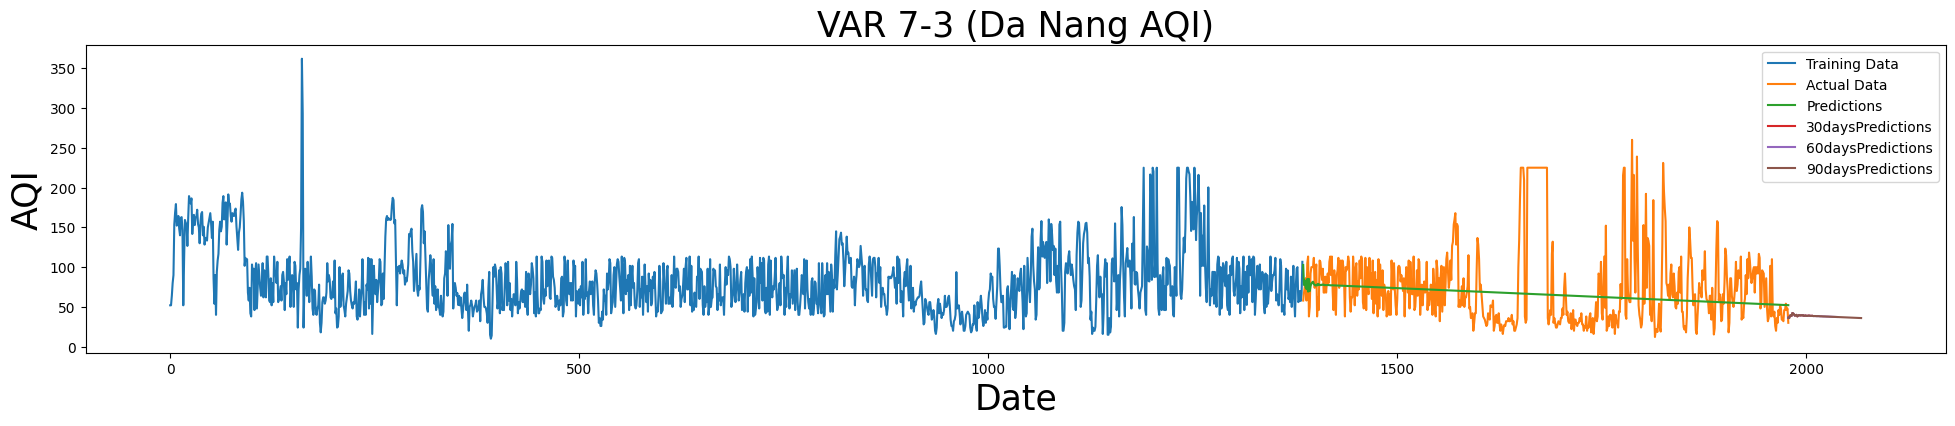

In [46]:
plt.figure(figsize=(24, 4))
plt.plot(train_data.index, train_data.AQI, label='Training Data')
plt.plot(test_data.index, test_data.AQI, label='Actual Data')
plt.plot(test_data.index, df_results.AQI_forecast, label='Predictions')  

plt.plot(prediect_data_index, df_results_30days.AQI_forecast, label='30daysPredictions')
plt.plot(prediect_data_index_60, df_results_60days.AQI_forecast, label='60daysPredictions')
plt.plot(prediect_data_index_90, df_results_90days.AQI_forecast, label='90daysPredictions')

plt.title('VAR 7-3 (Da Nang AQI)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('AQI', fontsize=25)
plt.legend()
plt.show()